<a href="https://colab.research.google.com/github/JohanRensfeldt/Application-Oriented-Deep-Learning-in-Physics/blob/main/Exercise_7_1_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them. 

In [2]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue). 

In [3]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([                                                                                                                                                                       
    'airplane',                                                                                                                                                                                   
    'automobile',                                                                                                                                                                                 
    'bird',                                                                                                                                                                                       
    'cat',                                                                                                                                                                                        
    'deer',                                                                                                                                                                                       
    'dog',                                                                                                                                                                                        
    'frog',                                                                                                                                                                                       
    'horse',                                                                                                                                                                                      
    'ship',                                                                                                                                                                                       
    'truck'])  

170508288/170498071 [==============================] - 11s 0us/step
images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


In [4]:
# Hint: To plot example images, you can use the plot examples function
# plot_examples(x_train, y_train)

In [8]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

# normalize images to range [0, 1]
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0
x_valid_norm = x_train_norm[40000:]
x_train_norm = x_train_norm[:40000]

y_valid_onehot = y_train_onehot[40000:]
y_train_onehot = y_train_onehot[:40000]

# Hint: normalize the data
# Hint: use 20% of the training data for validation


We start with a fully connected network

In [7]:
# ----------------------------------------------------------
# Define model
# ----------------------------------------------------------
model = tf.keras.models.Sequential(
    [
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        # this time the flatten operation is directly integrated into the network 
        # structure so that we can use the same input data later for a convolutional neural network. 
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax"),
        # Hint: remember that the output layer should have 10 nodes with a softmax activation
    ],
    name="nn",
)

print(model.summary())

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               786688    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable pa

In [10]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=20, # train at least for 20 epochs
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
1250/1250 - 8s - loss: 2.0773 - accuracy: 0.2133 - val_loss: 1.9290 - val_accuracy: 0.2861 - 8s/epoch - 6ms/step
Epoch 2/20
1250/1250 - 4s - loss: 1.9868 - accuracy: 0.2448 - val_loss: 1.8872 - val_accuracy: 0.3180 - 4s/epoch - 3ms/step
Epoch 3/20
1250/1250 - 4s - loss: 1.9500 - accuracy: 0.2639 - val_loss: 1.8723 - val_accuracy: 0.3263 - 4s/epoch - 3ms/step
Epoch 4/20
1250/1250 - 4s - loss: 1.9340 - accuracy: 0.2738 - val_loss: 1.8880 - val_accuracy: 0.3215 - 4s/epoch - 3ms/step
Epoch 5/20
1250/1250 - 4s - loss: 1.9272 - accuracy: 0.2781 - val_loss: 1.8773 - val_accuracy: 0.3265 - 4s/epoch - 3ms/step
Epoch 6/20
1250/1250 - 4s - loss: 1.9214 - accuracy: 0.2808 - val_loss: 1.9424 - val_accuracy: 0.2967 - 4s/epoch - 3ms/step
Epoch 7/20
1250/1250 - 4s - loss: 1.9161 - accuracy: 0.2840 - val_loss: 1.8624 - val_accuracy: 0.3351 - 4s/epoch - 3ms/step
Epoch 8/20
1250/1250 - 4s - loss: 1.9109 - accuracy: 0.2871 - val_loss: 1.9034 - val_accuracy: 0.3020 - 4s/epoch - 3ms/step
Epoch 9/

the accuracy is 0.30 and val acc is 0.36





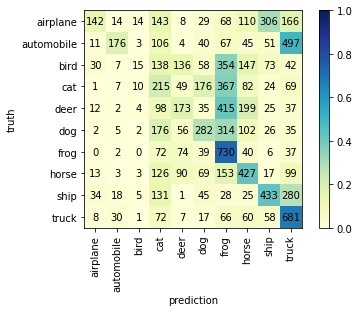

In [12]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)


# Hint: this is how you can plot the confusion matrix. 
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

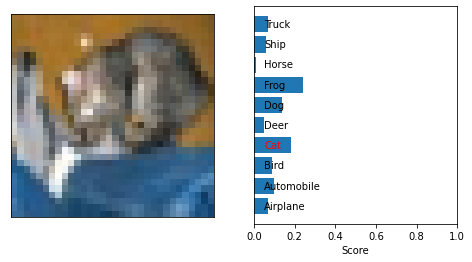

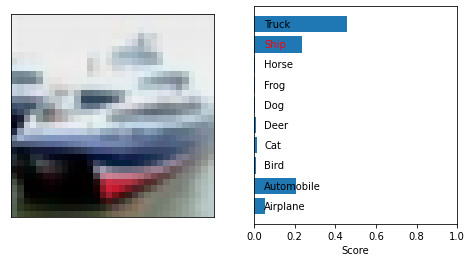

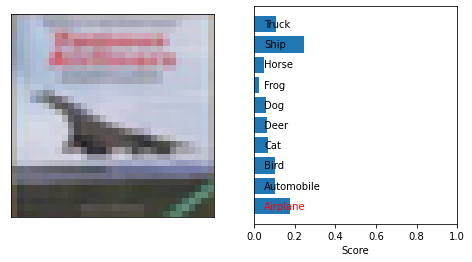

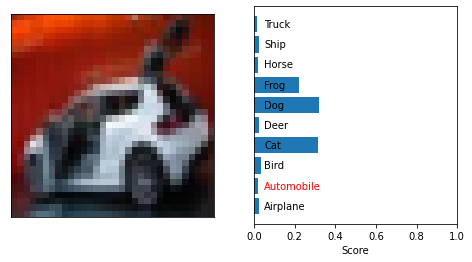

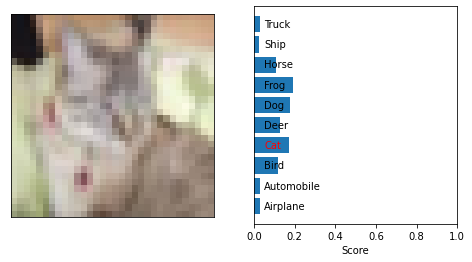

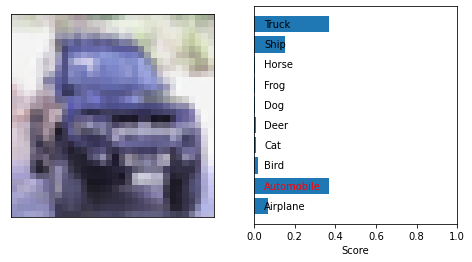

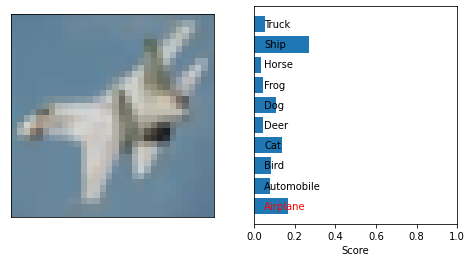

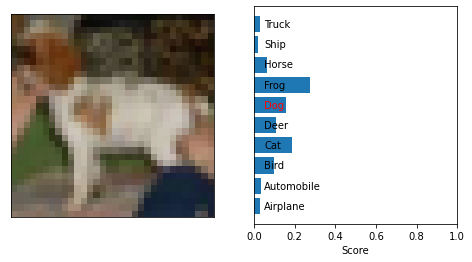

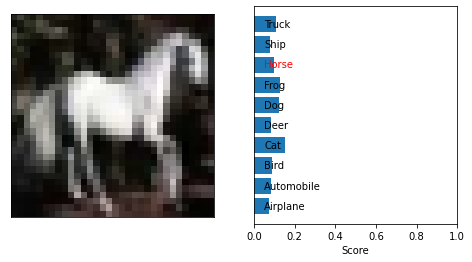

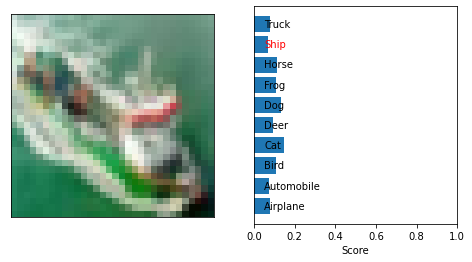

In [15]:
# Task: plot a few examples of correctly and incorrectly classified images. 
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(10000)[~m]  # misclassified images
i1 = np.arange(10000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:10000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [17]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see 
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size = (3,3), padding = "same", activation= 'relu', input_shape = (32,32,3)), # add additional convolution layer and max pooling layer here, 
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax"),
         # add dropout and output layer
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0       

In [18]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],

)

model.fit(
    x_train_norm,
    y_train_onehot,

    batch_size=32,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/40
1250/1250 [==============================] - 12s 5ms/step - loss: 1.5815 - accuracy: 0.4343 - val_loss: 1.3542 - val_accuracy: 0.5197
Epoch 2/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3015 - accuracy: 0.5410 - val_loss: 1.2072 - val_accuracy: 0.5818
Epoch 3/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2015 - accuracy: 0.5797 - val_loss: 1.1366 - val_accuracy: 0.6105
Epoch 4/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1304 - accuracy: 0.6042 - val_loss: 1.0817 - val_accuracy: 0.6366
Epoch 5/40
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0772 - accuracy: 0.6242 - val_loss: 1.0557 - val_accuracy: 0.6376
Epoch 6/40
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0365 - accuracy: 0.6359 - val_loss: 1.0324 - val_accuracy: 0.6434
Epoch 7/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0097 - accuracy: 0.6512 - val_loss: 1.0198 - val_accuracy